In [412]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

In [413]:
directory = os.path.abspath("") + '/dataset/ethereum/'
data = pd.read_csv(directory + 'data.csv', on_bad_lines = 'skip')
ECDSA = data.copy()

In [414]:
# Drop blocks with no transactions
ECDSA = ECDSA[ECDSA['TotalTx'] != 0]

# Average block size in bytes - block header size (512 bytes)
ECDSA['BlockSize'] = ECDSA['BlockSize'] - 512

ECDSA['AvgTxSize'] = ECDSA['BlockSize'] / ECDSA['TotalTx']

ECDSA['Date'] = ECDSA['Timestamp'].apply(lambda x: datetime.utcfromtimestamp(x))

ECDSA['FeePerBlock'] = ECDSA['GasUsed'] * ECDSA['BaseFeePerGas']

ECDSA['AvgTxGas'] = ECDSA['GasUsed'] / ECDSA['TotalTx']

# ECDSA['AvgFeePerTx'] = ECDSA['FeePerBlock'] / ECDSA['TotalTx']
ECDSA['AvgFeePerTx'] = ECDSA['AvgTxGas'] * ECDSA['BaseFeePerGas']

# Max No of Transactions possible in a 12 MB
ECDSA['NoMaxTxPossible'] = (12 * 1000000) / ECDSA['AvgTxSize']

ECDSA.describe()

,BlockNumber,Timestamp,BlockReward,BlockSize,TotalTx,GasUsed,GasAvgPrice,BlockTime,BaseFeePerGas,AvgTxSize,Date,FeePerBlock,AvgTxGas,AvgFeePerTx,NoMaxTxPossible
count,2.693665e+06,2.693665e+06,2.693665e+06,2.693665e+06,2.693665e+06,2.693665e+06,2.693665e+06,2.693665e+06,2.693665e+06,2.693665e+06,2693665,2.693665e+06,2.693665e+06,2.693665e+06,2.693665e+06
mean,1.780538e+07,1.690694e+09,8.210744e-02,1.396076e+05,1.488773e+02,1.512352e+07,3.341400e-08,1.212839e+01,2.797172e-08,9.842925e+02,2023-07-30 05:13:25.797916672,4.197992e-01,1.075130e+05,2.896514e-03,1.931178e+04
min,1.645497e+07,1.674302e+09,0.000000e+00,1.210000e+02,1.000000e+00,2.100000e+04,4.724384e-09,1.200000e+01,3.996741e-09,1.110508e+02,2023-01-21 11:46:35,2.257098e-04,2.100000e+04,1.114531e-04,1.849682e+02
25%,1.713023e+07,1.682510e+09,2.459373e-02,6.163600e+04,1.200000e+02,1.162459e+07,1.803205e-08,1.200000e+01,1.493489e-08,4.299417e+02,2023-04-26 11:54:23,2.044320e-01,8.507866e+04,1.495036e-03,9.636653e+03
50%,1.780544e+07,1.690715e+09,4.236888e-02,1.021630e+05,1.400000e+02,1.399854e+07,2.628430e-08,1.200000e+01,2.220459e-08,6.823379e+02,2023-07-30 11:04:47,3.244982e-01,9.736411e+04,2.249297e-03,1.758659e+04
75%,1.848048e+07,1.698881e+09,7.913076e-02,1.768990e+05,1.640000e+02,1.731431e+07,3.973690e-08,1.200000e+01,3.396361e-08,1.245246e+03,2023-11-01 23:16:47,5.114681e-01,1.140849e+05,3.451044e-03,2.791076e+04
max,1.915573e+07,1.707059e+09,1.822103e+02,2.332655e+06,1.366000e+03,3.002708e+07,9.472830e-06,9.600000e+01,8.132266e-07,6.487600e+04,2024-02-04 15:06:23,1.653241e+01,3.000000e+07,9.239259e-01,1.080586e+05
std,7.796217e+05,9.457689e+06,3.078260e-01,1.227419e+05,5.691164e+01,5.336105e+06,3.027426e-08,1.255729e+00,2.224686e-08,9.271744e+02,NaN,3.712858e-01,9.051606e+04,2.876701e-03,1.125013e+04


Text(0.5, 1.0, 'Correlation between features')

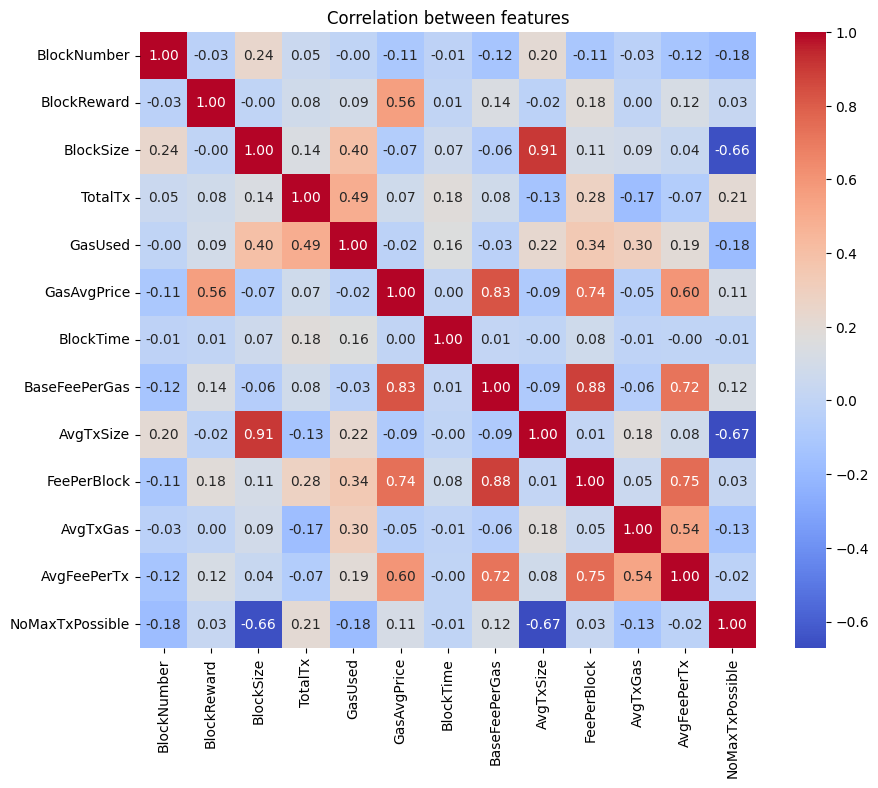

In [415]:
ECDSA_CORR = ECDSA.copy().drop(labels=['Timestamp', 'Date'], axis=1).corr()
plt.figure(figsize=(10,8))
sns.heatmap(ECDSA_CORR, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10},
           cmap= 'coolwarm')
plt.title('Correlation between features')

In [416]:
def getPQAvgTransactionSize(ECDSATxSize, PQ_SIG_SIZE: int):
    
    # ECDSA (bytes)
    ECDSA_SIG_SIZE = 65

    PQ_TxSize = ECDSATxSize - ECDSA_SIG_SIZE + PQ_SIG_SIZE

    return PQ_TxSize

In [417]:
FALCON_512_SIG_SIZE = 666 # (bytes)

FALCON = pd.DataFrame()

FALCON['AvgTxSize'] = getPQAvgTransactionSize(ECDSA['AvgTxSize'], FALCON_512_SIG_SIZE)

# Max No of Transactions possible in a 12 MB
FALCON['NoMaxTxPossible'] = (12 * 1000000) / FALCON['AvgTxSize']

FALCON['Date'] = ECDSA['Date']

# Since a basic transaction requires 21000 units of Gas (minimum), we can use it as a reference
FALCON['AvgTxGas'] = (21000 * FALCON['AvgTxSize']) / ECDSA['AvgTxSize'].min()

FALCON['AvgFeePerTx'] = FALCON['AvgTxGas'] * ECDSA['BaseFeePerGas']

FALCON.describe()

,AvgTxSize,NoMaxTxPossible,Date,AvgTxGas,AvgFeePerTx
count,2.693665e+06,2.693665e+06,2693665,2.693665e+06,2.693665e+06
mean,1.585293e+03,8.985731e+03,2023-07-30 05:13:25.797916672,2.997829e+05,8.045833e-03
min,7.120508e+02,1.832705e+02,2023-01-21 11:46:35,1.346506e+05,6.100338e-04
25%,1.030942e+03,6.499677e+03,2023-04-26 11:54:23,1.949537e+05,3.845848e-03
50%,1.283338e+03,9.350616e+03,2023-07-30 11:04:47,2.426825e+05,5.990811e-03
75%,1.846246e+03,1.163984e+04,2023-11-01 23:16:47,3.491298e+05,9.453329e-03
max,6.547700e+04,1.685273e+04,2024-02-04 15:06:23,1.238187e+07,8.385537e-01
std,9.271744e+02,3.026861e+03,NaN,1.753311e+05,8.180708e-03


In [418]:
DILITHIUM_SIG_SIZE = 2420 # (bytes)

DILITHIUM = pd.DataFrame()

DILITHIUM['AvgTxSize'] = getPQAvgTransactionSize(ECDSA['AvgTxSize'], DILITHIUM_SIG_SIZE)

# Max No of Transactions possible in a 12 MB
DILITHIUM['NoMaxTxPossible'] = (12 * 1000000) / DILITHIUM['AvgTxSize']

DILITHIUM['Date'] = ECDSA['Date']

# Since a basic transaction requires 21000 units of Gas (minimum), we can use it as a reference
DILITHIUM['AvgTxGas'] = (21000 * DILITHIUM['AvgTxSize']) / ECDSA['AvgTxSize'].min()

DILITHIUM['AvgFeePerTx'] = DILITHIUM['AvgTxGas'] * ECDSA['BaseFeePerGas']

DILITHIUM.describe()

,AvgTxSize,NoMaxTxPossible,Date,AvgTxGas,AvgFeePerTx
count,2.693665e+06,2.693665e+06,2693665,2.693665e+06,2.693665e+06
mean,3.339293e+03,3.759527e+03,2023-07-30 05:13:25.797916672,6.314688e+05,1.732366e-02
min,2.466051e+03,1.784891e+02,2023-01-21 11:46:35,4.663365e+05,1.985296e-03
25%,2.784942e+03,3.333106e+03,2023-04-26 11:54:23,5.266396e+05,9.137411e-03
50%,3.037338e+03,3.950828e+03,2023-07-30 11:04:47,5.743684e+05,1.361085e-02
75%,3.600246e+03,4.308887e+03,2023-11-01 23:16:47,6.808157e+05,2.083901e-02
max,6.723100e+04,4.866080e+03,2024-02-04 15:06:23,1.271355e+07,8.840695e-01
std,9.271744e+02,6.684745e+02,NaN,1.753311e+05,1.424694e-02


In [419]:
SPHINCS_SIG_SIZE = 17088 # (bytes)

SPHINCS = pd.DataFrame()

SPHINCS['AvgTxSize'] = getPQAvgTransactionSize(ECDSA['AvgTxSize'], SPHINCS_SIG_SIZE)

# Max No of Transactions possible in a 12 MB
SPHINCS['NoMaxTxPossible'] = (12 * 1000000) / SPHINCS['AvgTxSize']

SPHINCS['Date'] = ECDSA['Date']

# Since a basic transaction requires 21000 units of Gas (minimum), we can use it as a reference
SPHINCS['AvgTxGas'] = (21000 * SPHINCS['AvgTxSize']) / ECDSA['AvgTxSize'].min()

SPHINCS['AvgFeePerTx'] = SPHINCS['AvgTxGas'] * ECDSA['BaseFeePerGas']

SPHINCS.describe()

,AvgTxSize,NoMaxTxPossible,Date,AvgTxGas,AvgFeePerTx
count,2.693665e+06,2.693665e+06,2693665,2.693665e+06,2.693665e+06
mean,1.800729e+04,6.678558e+02,2023-07-30 05:13:25.797916672,3.405225e+06,9.491038e-02
min,1.713405e+04,1.465219e+02,2023-01-21 11:46:35,3.240093e+06,1.343213e-02
25%,1.745294e+04,6.568775e+02,2023-04-26 11:54:23,3.300396e+06,5.079460e-02
50%,1.770534e+04,6.777617e+02,2023-07-30 11:04:47,3.348125e+06,7.542493e-02
75%,1.826825e+04,6.875632e+02,2023-11-01 23:16:47,3.454572e+06,1.152719e-01
max,8.189900e+04,7.003598e+02,2024-02-04 15:06:23,1.548731e+07,2.706110e+00
std,9.271744e+02,2.890300e+01,NaN,1.753311e+05,7.485890e-02


#### AVERAGE TRANSACTIONS PER SECOND

> Average TPS = (Average Block Size / Average Transaction Size) / Average Block Time

In [420]:
ECDSA['AverageTPS'] = (ECDSA['BlockSize'] / ECDSA['AvgTxSize']) / ECDSA['BlockTime']
FALCON['AverageTPS'] = (ECDSA['BlockSize'] / FALCON['AvgTxSize']) / ECDSA['BlockTime']
DILITHIUM['AverageTPS'] = (ECDSA['BlockSize'] / DILITHIUM['AvgTxSize']) / ECDSA['BlockTime']
SPHINCS['AverageTPS'] = (ECDSA['BlockSize'] / SPHINCS['AvgTxSize']) / ECDSA['BlockTime']

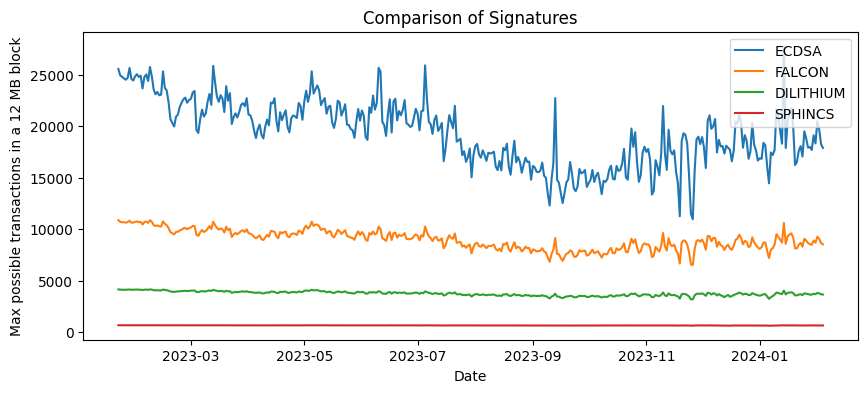

In [421]:
ECDSA_resampled = ECDSA.resample('1d', on='Date').mean()
FALCON_resampled = FALCON.resample('1d', on='Date').mean()
DILITHIUM_resampled = DILITHIUM.resample('1d', on='Date').mean()
SPHINCS_resampled = SPHINCS.resample('1d', on='Date').mean()

plt.figure(figsize=(10, 4))
plt.plot(ECDSA_resampled['NoMaxTxPossible'], label='ECDSA')
plt.plot(FALCON_resampled['NoMaxTxPossible'], label='FALCON')
plt.plot(DILITHIUM_resampled['NoMaxTxPossible'], label='DILITHIUM')
plt.plot(SPHINCS_resampled['NoMaxTxPossible'], label='SPHINCS')

plt.xlabel('Date')
plt.ylabel('Max possible transactions in a 12 MB block')
plt.title('Comparison of Signatures')
plt.legend()
plt.show()

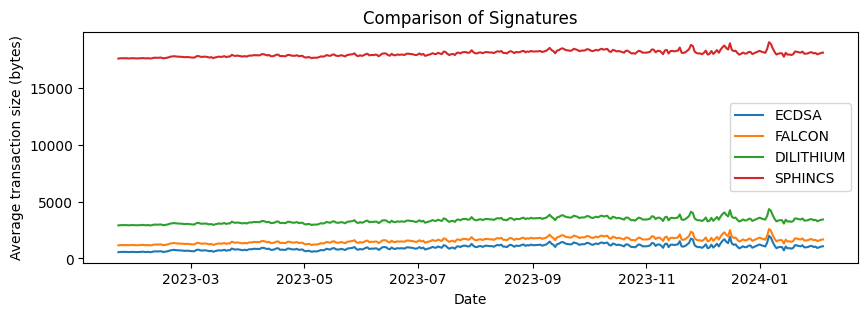

In [422]:
plt.figure(figsize=(10, 3))

plt.plot(ECDSA_resampled['AvgTxSize'], label='ECDSA')
plt.plot(FALCON_resampled['AvgTxSize'], label='FALCON')
plt.plot(DILITHIUM_resampled['AvgTxSize'], label='DILITHIUM')
plt.plot(SPHINCS_resampled['AvgTxSize'], label='SPHINCS')

plt.xlabel('Date')
plt.ylabel('Average transaction size (bytes)')
plt.title('Comparison of Signatures')
plt.legend()
plt.show()

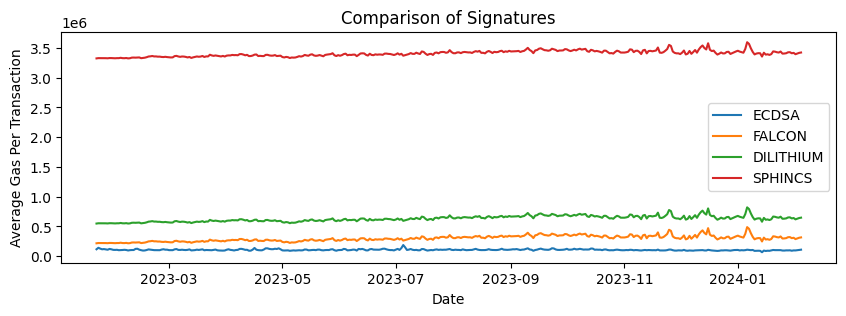

In [423]:
plt.figure(figsize=(10, 3))

plt.plot(ECDSA_resampled['AvgTxGas'], label='ECDSA')
plt.plot(FALCON_resampled['AvgTxGas'], label='FALCON')
plt.plot(DILITHIUM_resampled['AvgTxGas'], label='DILITHIUM')
plt.plot(SPHINCS_resampled['AvgTxGas'], label='SPHINCS')

plt.xlabel('Date')
plt.ylabel('Average Gas Per Transaction')
plt.title('Comparison of Signatures')
plt.legend()
plt.show()

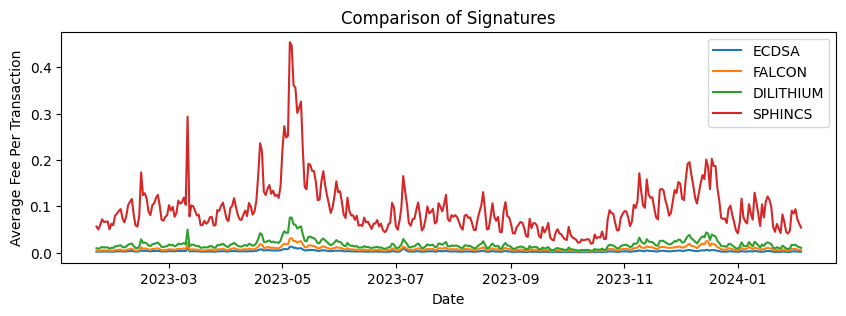

In [424]:
plt.figure(figsize=(10, 3))

plt.plot(ECDSA_resampled['AvgFeePerTx'], label='ECDSA')
plt.plot(FALCON_resampled['AvgFeePerTx'], label='FALCON')
plt.plot(DILITHIUM_resampled['AvgFeePerTx'], label='DILITHIUM')
plt.plot(SPHINCS_resampled['AvgFeePerTx'], label='SPHINCS')

plt.xlabel('Date')
plt.ylabel('Average Fee Per Transaction')
plt.title('Comparison of Signatures')
plt.legend()
plt.show()

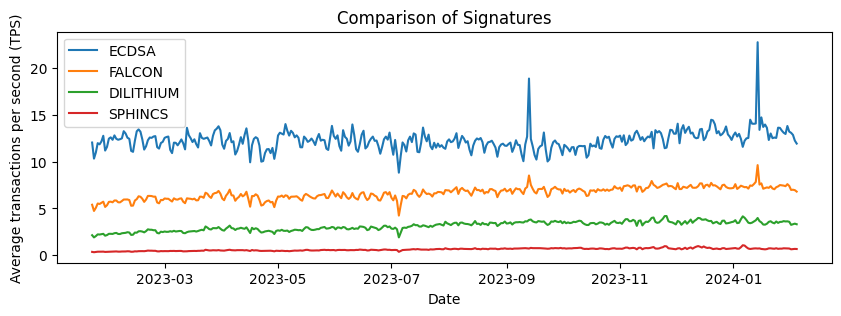

In [425]:
plt.figure(figsize=(10, 3))

plt.plot(ECDSA_resampled['AverageTPS'], label='ECDSA')
plt.plot(FALCON_resampled['AverageTPS'], label='FALCON')
plt.plot(DILITHIUM_resampled['AverageTPS'], label='DILITHIUM')
plt.plot(SPHINCS_resampled['AverageTPS'], label='SPHINCS')

plt.xlabel('Date')
plt.ylabel('Average transactions per second (TPS)')
plt.title('Comparison of Signatures')
plt.legend()
plt.show()